# Imports

In [202]:
# Import package EquiPy (pip install from GitHub to have the latest version)
from equipy import metrics
from equipy import fairness
from equipy import graphs
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
np.random.seed(2000)

In [203]:
# Import dataset
df = pd.read_csv('../data/frenchmotor.csv')
print("Number of rows in the dataset: ", df.shape[0])
print("Number of columns in the dataset: ", df.shape[1])

Number of rows in the dataset:  12437
Number of columns in the dataset:  18


In [204]:
print("Column types:\n", df.dtypes)

Column types:
 LicAge          int64
VehAge         object
sensitive      object
MariStat       object
SocioCateg     object
VehUsage       object
DrivAge         int64
HasKmLimit      int64
BonusMalus      int64
VehBody        object
VehPrice       object
VehEngine      object
VehEnergy      object
VehMaxSpeed    object
VehClass       object
y               int64
RiskVar         int64
Garage         object
dtype: object


/var/folders/s0/9my1yr7920lfy9vmb78bvjch0000gn/T/ipykernel_1871/102108413.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Age'][df['DrivAge']>=65] = '65+'
/var/folders/s0/9my1yr7920lfy9vmb78bvjch0000gn/T/ipykernel_1871/102108413.py:

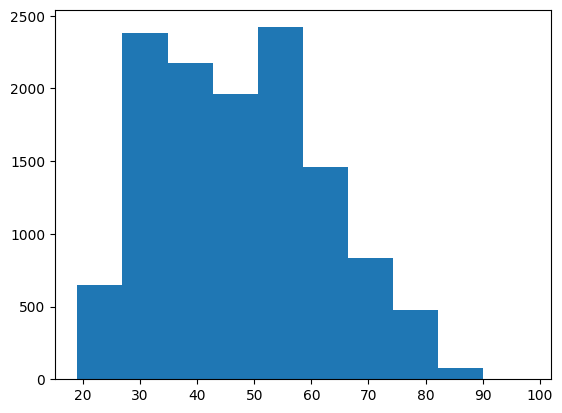

In [205]:
# Define classes on the driver's age to have a categorical sensitive attribute
# 5 classes
#num_quantiles = 5

# Add this new column to the dataframe and delete the former one
#df['Age'] = pd.qcut(df['DrivAge'], q=num_quantiles, labels=False, duplicates='drop')
#df.drop('DrivAge', axis=1, inplace=True)
plt.hist(df['DrivAge'])
df['Age'] = '65-'
df['Age'][df['DrivAge']>=65] = '65+'
df.drop('DrivAge', axis=1, inplace=True)

In [206]:
df['Age'].value_counts()

Age
65-    10797
65+     1640
Name: count, dtype: int64

In [207]:
np.sum(df['y']==1)/np.shape(df)[0]*100

8.675725657312856

In [208]:
# Perform one-hot encoding for categorical variables to apply Random Forest
df_encoded = pd.get_dummies(df, columns=['VehAge', 'sensitive', 'MariStat', 'SocioCateg', 
                                         'VehUsage', 'VehBody', 'VehPrice', 'VehEngine', 
                                         'VehEnergy', 'VehMaxSpeed', 'VehClass', 'Garage',
                                         'Age'], drop_first=True)

In [209]:
# Split the data into train, calibration and test sets
# During mitigation, we will need the calibration set and we won't touch the train set
X = df_encoded.drop("y", axis=1)
y = df_encoded["y"]

# Splitting into two datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary set into calibration and test sets
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [210]:
# Imbalanced dataset
np.sum(y == 1)/np.size(y)*100

8.675725657312856

In [172]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf = 100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Get predicted scores of calibration and test sets
scores_train = rf_classifier.predict_proba(X_train)[:, 1]
scores_calib = rf_classifier.predict_proba(X_calib)[:, 1]
scores_test = rf_classifier.predict_proba(X_test)[:, 1]

In [211]:
from sklearn.linear_model import LogisticRegression

# Create and train the logistic regression model
LR = LogisticRegression()
LR.fit(X_train, y_train)

# Get predicted scores of calibration and test sets
scores_train = LR.predict_proba(X_train)[:, 1]
scores_calib = LR.predict_proba(X_calib)[:, 1]
scores_test = LR.predict_proba(X_test)[:, 1]


/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [106]:
# Create a XGB classifier : gives best results than RF classifier
#from xgboost import XGBClassifier
#xgb = XGBClassifier(n_estimators = 100, min_child_weight = 3)

# Train the model on the training data
#xgb.fit(X_train, y_train)

# Get predicted scores of calibration and test sets
#scores_train = xgb.predict_proba(X_train)[:, 1]
#scores_calib = xgb.predict_proba(X_calib)[:, 1]
#scores_test = xgb.predict_proba(X_test)[:, 1]

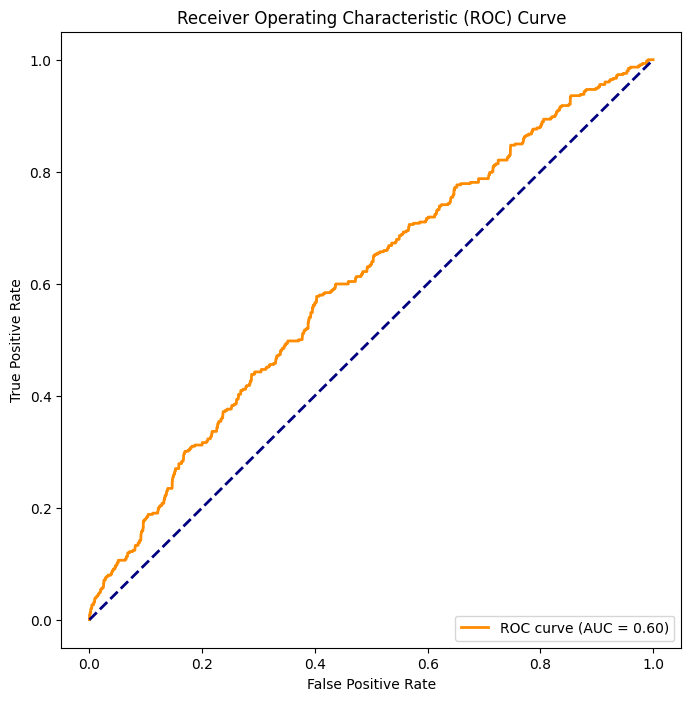

In [212]:
# ROC curve on calibration and test sets

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area under the curve (AUC)
y_true = np.concatenate((y_calib, y_test))
scores = np.concatenate((scores_calib, scores_test))
fpr, tpr, thresholds = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Display the plot
plt.show()

# Find the optimal threshold based on the ROC curve for calibration and test sets
#optimal_threshold_index = np.argmax(tpr - fpr)
#optimal_threshold = thresholds[optimal_threshold_index]

#print("Optimal Threshold:", optimal_threshold)


In [213]:
from sklearn.metrics import f1_score
# Define a range of thresholds to evaluate
thresholds = np.arange(0.1, 1.0, 0.01)
# Initialize variables to store optimal values
best_threshold = 0
best_f1 = 0

# Iterate through thresholds and calculate F1 score
for threshold in thresholds:
    #y_true = np.concatenate((y_calib, y_test))
    #scores = np.concatenate((scores_calib, scores_test))
    predicted_labels = (scores_train > threshold).astype(int)
    f1 = f1_score(y_train, predicted_labels)
    
    # Update optimal values if F1 score is higher
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Print the optimal threshold and F1 score
print(f"Optimal Threshold: {best_threshold:.2f}")
print(f"Optimal F1 Score: {best_f1:.4f}")

Optimal Threshold: 0.10
Optimal F1 Score: 0.2222


In [214]:
# Define classes on predicted scores for each dataset
threshold = best_threshold
y_pred_train = (scores_train > threshold).astype(int)
y_pred_calib = (scores_calib > threshold).astype(int)
y_pred_test = (scores_test > threshold).astype(int)

In [215]:
# Evaluate the classifier : no overfitting
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_calib = accuracy_score(y_calib, y_pred_calib)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on train dataset: {accuracy_train:.2f}")
print(f"Accuracy on calibration dataset: {accuracy_calib:.2f}")
print(f"Accuracy on test dataset: {accuracy_test:.2f}")

Accuracy on train dataset: 0.73
Accuracy on calibration dataset: 0.69
Accuracy on test dataset: 0.70


In [216]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Calculate confusion matrix on test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
# Calculate precision
precision = precision_score(y_test, y_pred_test)
# Calculate recall
recall = recall_score(y_test, y_pred_test)

print("Confusion matrix on test dataset:\n", conf_matrix)
print(f"Precision on test dataset: {precision:.2f}")
print(f"Recall on test dataset: {recall:.2f}")

Confusion matrix on test dataset:
 [[1634  609]
 [ 135  110]]
Precision on test dataset: 0.15
Recall on test dataset: 0.45


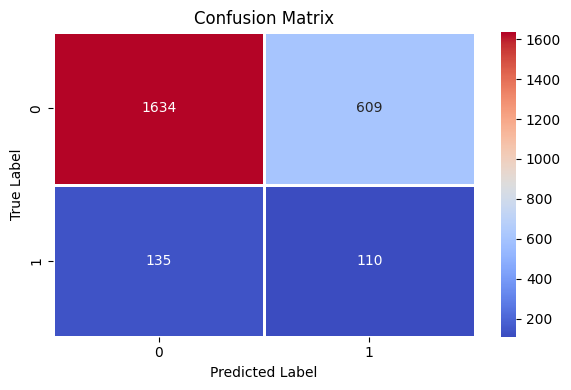

In [217]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

LABELS = ['0', '1']

def show_confusion_matrix(observations, predictions, title=None):
    matrix = confusion_matrix(observations, predictions)

    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    #plt.savefig("../images/MLP_1000epochs_cm.png")
    plt.show()

show_confusion_matrix(y_test, y_pred_test)

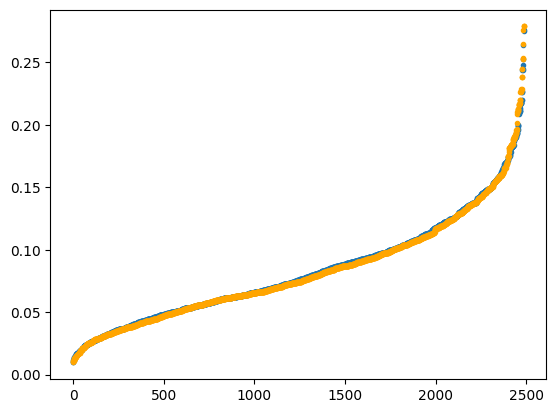

In [218]:
# Plot distributions
plt.plot(sorted(scores_calib), '.')
plt.plot(sorted(scores_test), '.', color = "orange")
plt.show()

In [219]:
# Test and calibration datasets without one-hot encoding
df_calib = df.loc[X_calib.index]
df_test = df.loc[X_test.index]
df_calib.rename(columns={'sensitive': 'Gender'}, inplace=True)
df_test.rename(columns={'sensitive': 'Gender'}, inplace=True)

In [220]:
df_calib.head(5)

,LicAge,VehAge,Gender,MariStat,SocioCateg,VehUsage,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,y,RiskVar,Garage,Age
8762,75,0,Female,Other,CSP37,Private,0,100,bus,M,injection overpowered,diesel,130-140 km/h,0,0,8,NaN,65-
2714,299,1,Male,Other,CSP50,Private+trip to office,0,51,sedan,M,direct injection overpowered,diesel,200-220 km/h,M2,0,12,Private garage,65-
7946,302,6-7,Male,Other,CSP48,Professional,0,50,van,L,injection,diesel,1-130 km/h,0,0,18,NaN,65-
251,616,0,Male,Other,CSP60,Private,0,51,sedan,Q,direct injection overpowered,diesel,200-220 km/h,H,0,16,Collective garage,65+
11248,166,8-9,Male,Other,CSP50,Private,0,64,other microvan,M,injection overpowered,diesel,150-160 km/h,H,0,17,NaN,65-


In [221]:
# Rename datasets to facilitate the EquiPy package application
# Creation of the objects useful for the package
x_ssa_calib = df_calib[['Gender','Age']].to_numpy()
x_ssa_test = df_test[['Gender','Age']].to_numpy()
# True outcome values (0/1)
y_true_calib = np.array(y_calib)
y_true_test = np.array(y_test)
# Predicted scores because EquiPy deals with real-valued outcomes

In [222]:
# Functions available in module fairness, graphs and metrics
print(dir(fairness))
print(dir(metrics))
print(dir(graphs))

['FairWasserstein', 'MultiWasserstein', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_base', '_wasserstein']
['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_fairness_metrics', '_performance_metrics', 'performance', 'unfairness']
['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_arrow_plot', '_density_plot', '_waterfall_plot', 'fair_arrow_plot', 'fair_density_plot', 'fair_multiple_arrow_plot', 'fair_waterfall_plot']


In [121]:
# Documentation of the class MultiWasserstein
#help(fairness.MultiWasserstein)

In [150]:
# Functions available in the class fairness.MultiWasserstein
class_functions = [function for function in dir(fairness.MultiWasserstein) if callable(getattr(fairness.MultiWasserstein, function))]
print("Functions of the class:", class_functions)

Functions of the class: ['__class__', '__delattr__', '__dir__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'fit', 'transform']


In [223]:
# Calculation of unfairness before applying mitigation
from equipy.metrics import unfairness
# We can't calculate the unfairness for the true values of y because it is not real-valued and only takes 0/1
# When doing classification task, we expect scores and not 0/1
unfairness(y_true_test, x_ssa_test)


1.0

# Exact fairness

In [224]:
# Instance of Wasserstein class : exact fairness
from equipy.fairness import MultiWasserstein
# Create instance of Wasserstein class (MSA)
exact_wst = MultiWasserstein()
# We calculate EQF, ECDF, weights on the calibration set
exact_wst.fit(scores_calib, x_ssa_calib)
# We apply those values to the test set to make it fair
# The transform function returns the final fair y, after mitigating biases from the 2 SA
# First SA : gender, Second : driver's age
y_final_fair = exact_wst.transform(scores_test, x_ssa_test)
print("y_fair :", y_final_fair) # returns the y_fair

y_fair : [0.14083462 0.10728543 0.05383105 ... 0.07478495 0.08826743 0.10340817]


## Unfairness and performance metrics

In [225]:
# Define dictionnaries with unfairness and performance metrics for different permutations of sensitive attributes
unfs_list = [{'Base model': 0, 'sens_var_1': 0, 'sens_var_2': 0},
             {'Base model': 0, 'sens_var_2': 0, 'sens_var_1': 0}]
perf_list = [{'Base model': 0, 'sens_var_1': 0, 'sens_var_2': 0},
              {'Base model': 0, 'sens_var_2': 0, 'sens_var_1': 0}]

In [226]:
# We can calculate fairness of the y_final_fair and on the initial scores_test
print("Unfairness before mitigation: ", unfairness(scores_test, x_ssa_test))
print("Unfairness after mitigating biases from gender and age: ", unfairness(y_final_fair, x_ssa_test))

Unfairness before mitigation:  0.04255387497333149
Unfairness after mitigating biases from gender and age:  0.014841602244951152


In [227]:
# To have all the steps of sequential fairness, we can take the dictionnary
# Dictionnary of sequential fair outputs if multiple sensitive attributes
y_seq_fair = exact_wst.y_fair
print("y_sequentially_fair :", y_seq_fair)

# Calculate sequential unfairness
print("Unfairness before mitigation: ", unfairness(y_seq_fair["Base model"], x_ssa_test))
unfs_list[0]['Base model'] = unfairness(y_seq_fair["Base model"], x_ssa_test)
# Sensitive features must be classes (multi-class is possible) ! The order depends on what the user has specified
print("Unfairness after mitigating biases from gender: ", unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test))
unfs_list[0]['sens_var_1'] = unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test)
print("Unfairness after mitigating biases from gender and age: ", unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test))
unfs_list[0]['sens_var_2'] = unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test)

y_sequentially_fair : {'Base model': array([0.14844431, 0.11249915, 0.04330445, ..., 0.07706058, 0.06971793,
       0.10762275]), 'sensitive_feature_1': array([0.13761686, 0.10347969, 0.0512521 , ..., 0.07148721, 0.08444948,
       0.09941112]), 'sensitive_feature_2': array([0.14083462, 0.10728543, 0.05383105, ..., 0.07478495, 0.08826743,
       0.10340817])}
Unfairness before mitigation:  0.04255387497333149
Unfairness after mitigating biases from gender:  0.03807315744590398
Unfairness after mitigating biases from gender and age:  0.014841602244951152


In [228]:
# We can do the same with metrics : on the final fair y
from equipy.metrics import performance
from sklearn.metrics import accuracy_score, f1_score
# We first need to transform scores predicted into 0/1 values
print("Accuracy before mitigation: ", performance(y_true_test, y_pred_test, accuracy_score))
print("F1-score before mitigation: ", performance(y_true_test, y_pred_test, f1_score))
# Transform y_final_fair into class vector (0/1)
# Set the threshold
print("Optimal threshold:", threshold)
# Convert scores to binary class predictions
class_final_fair = (y_final_fair > threshold).astype(int)
print("Accuracy after mitigating biases from gender and age: ", performance(y_true_test, class_final_fair, accuracy_score))
print("F1-score after mitigating biases from gender and age: ", performance(y_true_test, class_final_fair, f1_score))

# No loss in the accuracy

Accuracy before mitigation:  0.7009646302250804
F1-score before mitigation:  0.22821576763485477
Optimal threshold: 0.1
Accuracy after mitigating biases from gender and age:  0.6965434083601286
F1-score after mitigating biases from gender and age:  0.21599169262720663


/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classificat

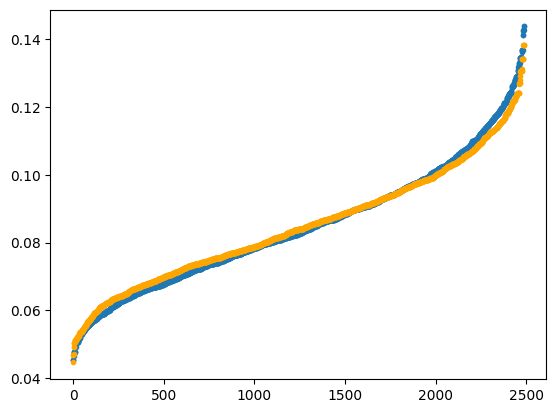

In [189]:
# Plot distributions of predicted scores and final fair scores for test set
plt.plot(sorted(scores_test), '.')
plt.plot(sorted(y_final_fair), '.', color = "orange")
plt.show()

In [229]:
# We can do the same with sequential fairness
metric = f1_score

# Calculate sequential accuracy
class_base_model = (y_seq_fair["Base model"] > threshold).astype(int)
print("Accuracy before mitigation: ", performance(y_true_test, class_base_model, metric))
perf_list[0]['Base model'] = performance(y_true_test, class_base_model, metric)
class_sa_1 = (y_seq_fair["sensitive_feature_1"] > threshold).astype(int)
print("Accuracy after mitigating biases from gender: ", performance(y_true_test, class_sa_1, metric))
perf_list[0]['sens_var_1'] = performance(y_true_test, class_sa_1, metric)
class_sa_2 = (y_seq_fair["sensitive_feature_2"] > threshold).astype(int)
print("Accuracy after mitigating biases from gender and age: ", performance(y_true_test, class_sa_2, metric))
perf_list[0]['sens_var_2'] = performance(y_true_test, class_sa_2, metric)

Accuracy before mitigation:  0.22821576763485477
Accuracy after mitigating biases from gender:  0.2277951933124347
Accuracy after mitigating biases from gender and age:  0.21599169262720663


/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classificat

## Same code but for a different order of sensitive attributes : Age then Gender

In [230]:
# Rename datasets to facilitate the EquiPy package application
# Creation of the objects useful for the package
x_ssa_calib = df_calib[['Age','Gender']].to_numpy()
x_ssa_test = df_test[['Age','Gender']].to_numpy()
# True outcome values (0/1)
y_true_calib = np.array(y_calib)
y_true_test = np.array(y_test)
# Predicted scores because EquiPy deals with real-valued outcomes
#scores_calib
#scores_test
# Instance of Wasserstein class : exact fairness
# Create instance of Wasserstein class (MSA)
exact_wst = MultiWasserstein()
# We calculate EQF, ECDF, weights on the calibration set
exact_wst.fit(scores_calib, x_ssa_calib)
# We apply those values to the test set to make it fair
# The transform function returns the final fair y, after mitigating biases from the 2 SA
# First SA : gender, Second : driver's age
y_final_fair = exact_wst.transform(scores_test, x_ssa_test)
#print("y_fair :", y_final_fair) # returns the y_fair
# To have all the steps of sequential fairness, we can take the dictionnary
y_seq_fair = exact_wst.y_fair
#print("y_sequentially_fair :", y_seq_fair)

# Calculate sequential unfairness
print("Unfairness before mitigation: ", unfairness(y_seq_fair["Base model"], x_ssa_test))
unfs_list[1]['Base model'] = unfairness(y_seq_fair["Base model"], x_ssa_test)
print("Unfairness after mitigating biases from age: ", unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test))
unfs_list[1]['sens_var_2'] = unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test)
print("Unfairness after mitigating biases from age and gender: ", unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test))
unfs_list[1]['sens_var_1'] = unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test)

# We can do the same with sequential fairness
metric = f1_score

# Calculate sequential accuracy
class_base_model = (y_seq_fair["Base model"] > threshold).astype(int)
print("Accuracy before mitigation: ", performance(y_true_test, class_base_model, metric))
perf_list[1]['Base model'] = performance(y_true_test, class_base_model, metric)
class_sa_1 = (y_seq_fair["sensitive_feature_1"] > threshold).astype(int)
print("Accuracy after mitigating biases from age: ", performance(y_true_test, class_sa_1, metric))
perf_list[1]['sens_var_2'] = performance(y_true_test, class_sa_1, metric)
class_sa_2 = (y_seq_fair["sensitive_feature_2"] > threshold).astype(int)
print("Accuracy after mitigating biases from age and gender: ", performance(y_true_test, class_sa_2, metric))
perf_list[1]['sens_var_1'] = performance(y_true_test, class_sa_2, metric)

Unfairness before mitigation:  0.04255387497333149
Unfairness after mitigating biases from age:  0.05294445553439375
Unfairness after mitigating biases from age and gender:  0.016912447852935802
Accuracy before mitigation:  0.22821576763485477
Accuracy after mitigating biases from age:  0.21509824198552224
Accuracy after mitigating biases from age and gender:  0.21878224974200206


/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classificat

## Visualizations

array([<Axes: title={'center': 'Base model'}, xlabel='Prediction', ylabel='Density'>,
       <Axes: title={'center': 'Base model'}, xlabel='Prediction', ylabel='Density'>,
       <Axes: title={'center': 'sensitive_feature_1'}, xlabel='Prediction', ylabel='Density'>,
       <Axes: title={'center': 'sensitive_feature_1'}, xlabel='Prediction', ylabel='Density'>,
       <Axes: title={'center': 'sensitive_feature_2'}, xlabel='Prediction', ylabel='Density'>,
       <Axes: title={'center': 'sensitive_feature_2'}, xlabel='Prediction', ylabel='Density'>],
      dtype=object)

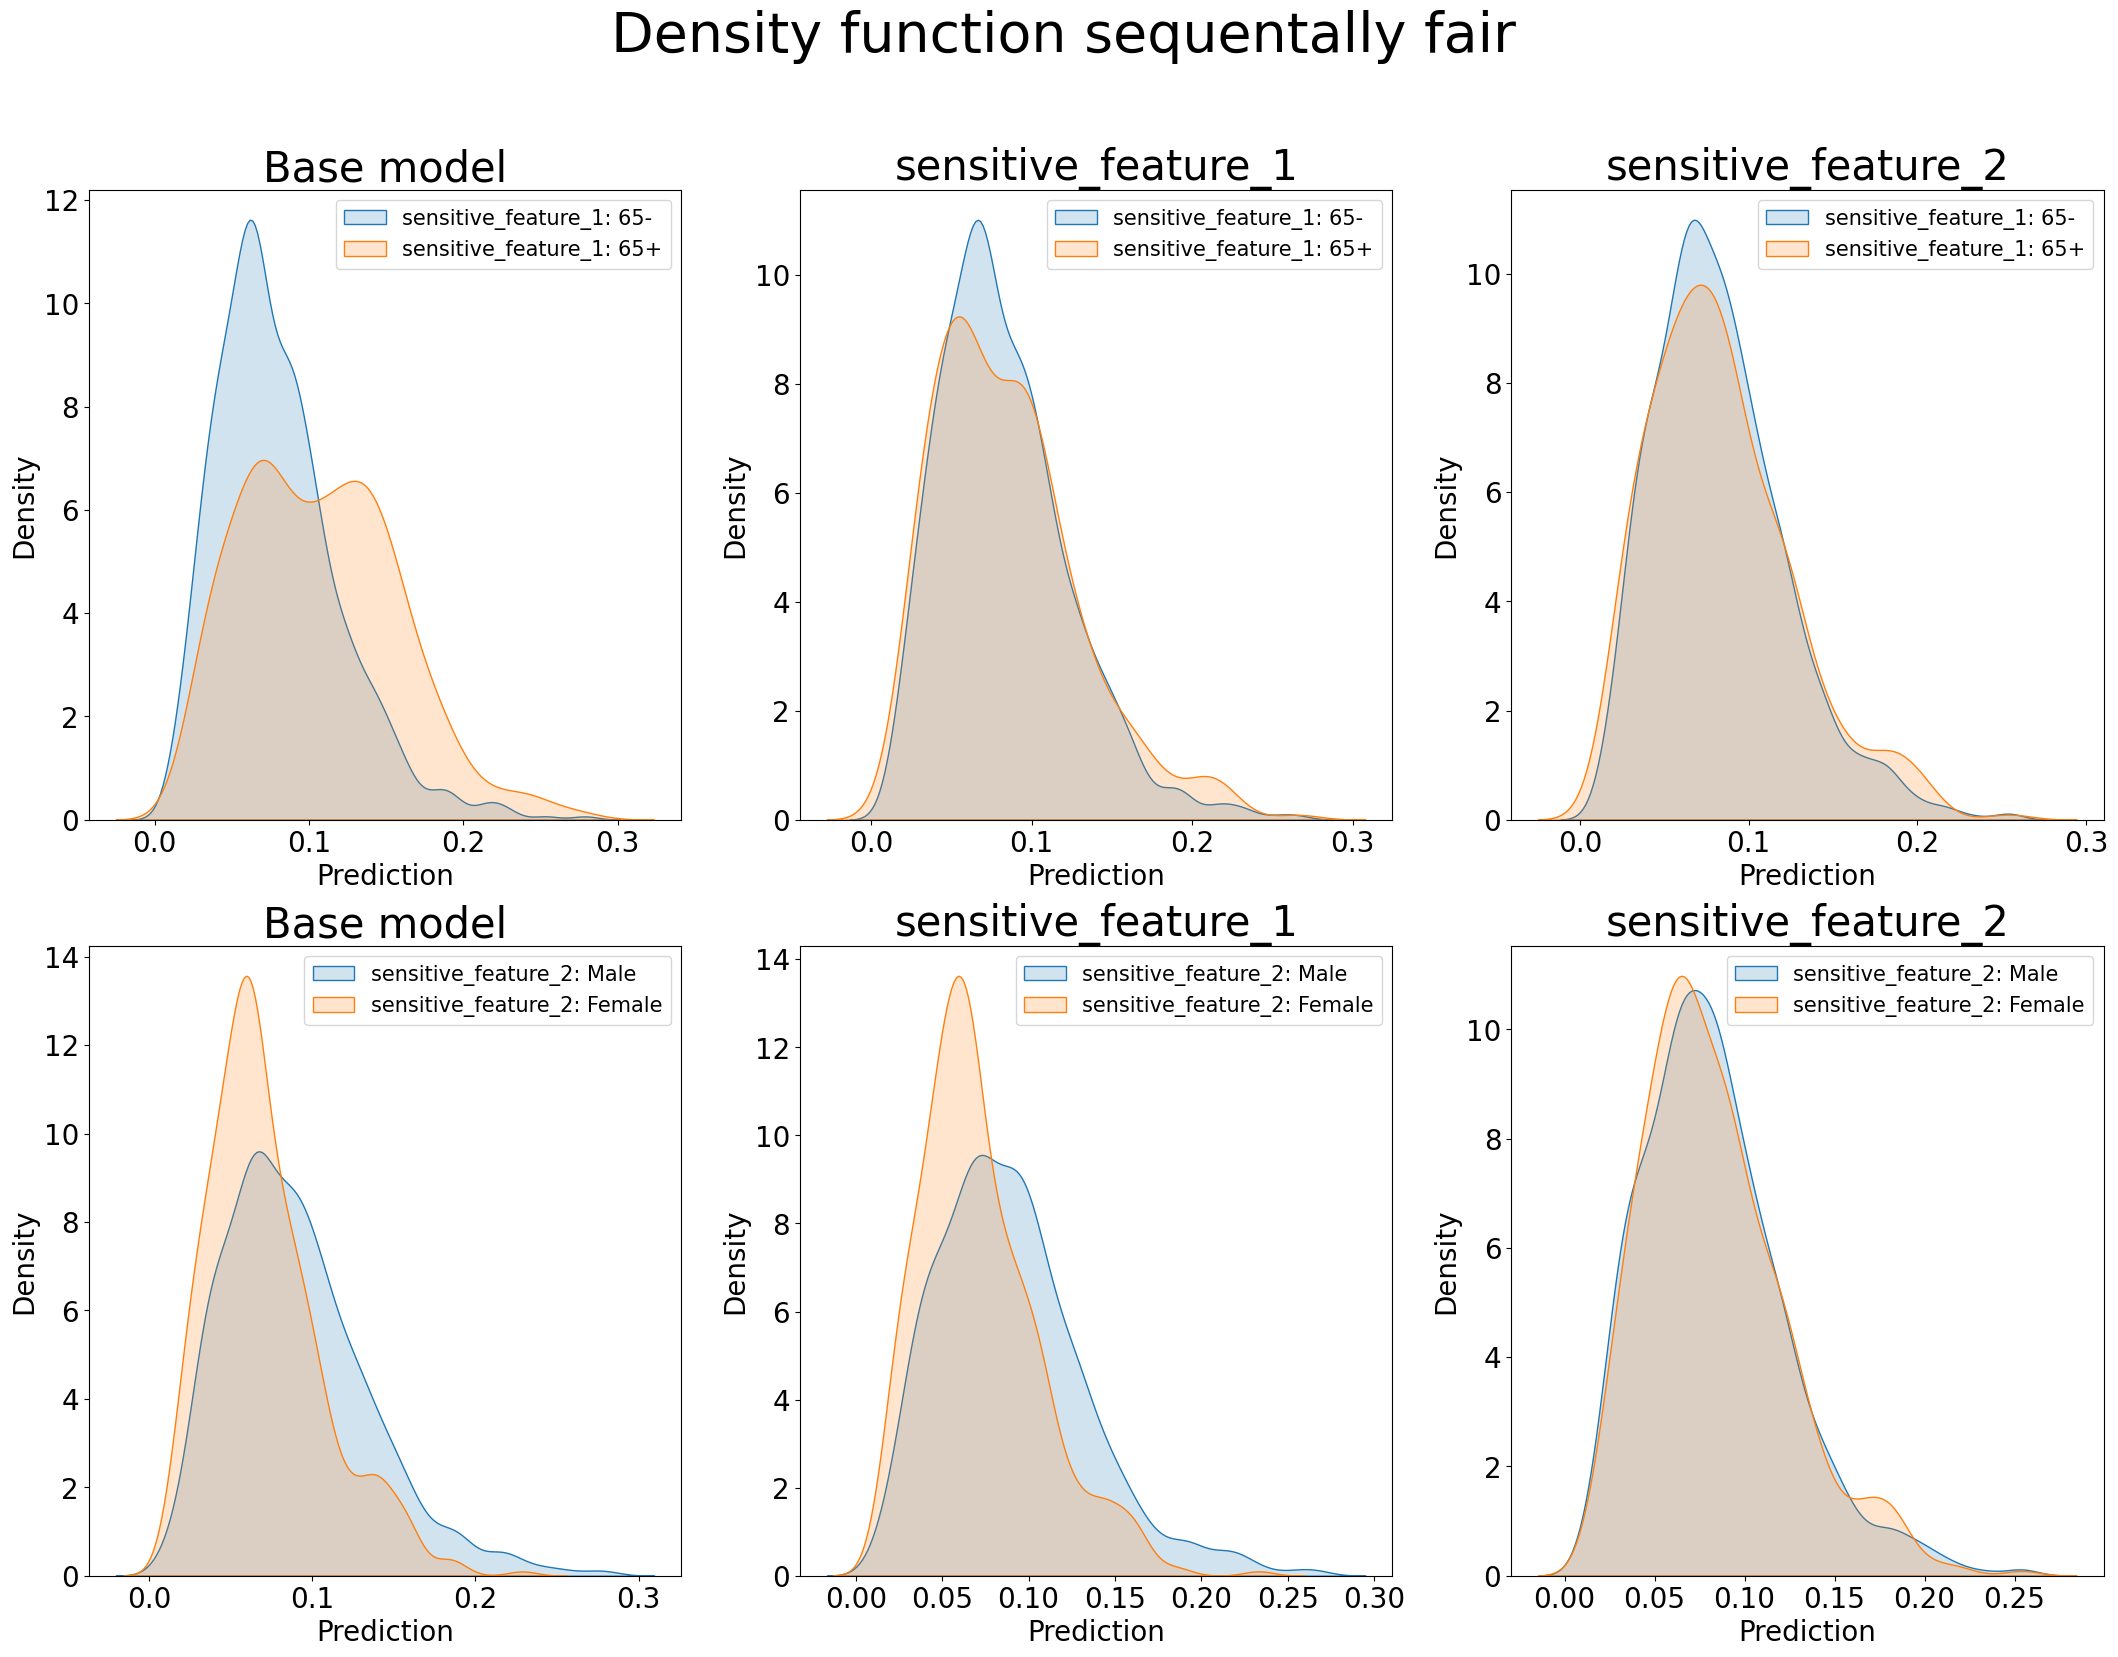

In [231]:
from equipy.graphs import fair_density_plot
fair_density_plot(y_seq_fair, x_ssa_test)

In [232]:
# By hand for now
print(unfs_list)
print(perf_list)

[{'Base model': 0.04255387497333149, 'sens_var_1': 0.03807315744590398, 'sens_var_2': 0.014841602244951152}, {'Base model': 0.04255387497333149, 'sens_var_2': 0.05294445553439375, 'sens_var_1': 0.016912447852935802}]
[{'Base model': 0.22821576763485477, 'sens_var_1': 0.2277951933124347, 'sens_var_2': 0.21599169262720663}, {'Base model': 0.22821576763485477, 'sens_var_2': 0.21509824198552224, 'sens_var_1': 0.21878224974200206}]


In [233]:
unfs_list[1]['sens_var_1'] = 0.014841602244951152
perf_list[1]['sens_var_1'] = 0.21599169262720663

[0.014841602244951152, 0.014841602244951152] [0.04255387497333149, 0.05294445553439375] [0.21599169262720663, 0.21509824198552224] [0.22821576763485477, 0.22821576763485477]


<Axes: title={'center': 'Exact fairness'}, xlabel='Unfairness', ylabel='Performance'>

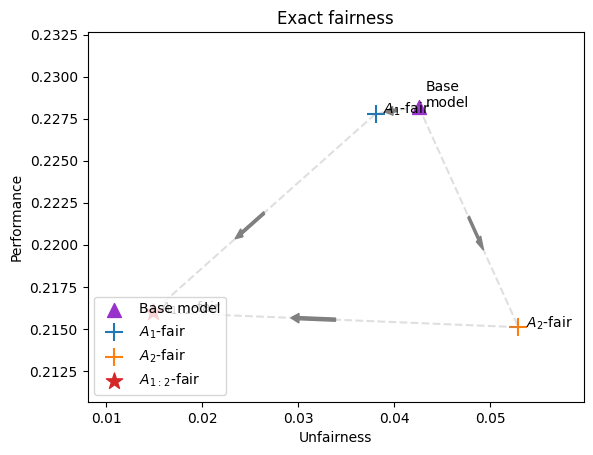

In [234]:
from equipy.graphs import fair_arrow_plot, fair_multiple_arrow_plot

# Packages to import to apply functions at hand
import re

def fair_arrow_plot(unfs_dict: dict[str, np.ndarray],
                    performance_dict: dict[str, np.ndarray],
                    permutations: bool = False,
                    base_model: bool = True,
                    final_model: bool = True) -> plt.Axes:
    """
    Generates an arrow plot representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness.

    Parameters
    ----------
    unfs_dict : dict
        A dictionary containing unfairness values associated with the sequentially fair output datasets.
    performance_dict : dict
        A dictionary containing performance values associated with the sequentially fair output datasets.
    permutations : bool, optional
        If True, displays permutations of arrows based on input dictionaries. Defaults to False.
    base_model : bool, optional
        If True, includes the base model arrow. Defaults to True.
    final_model : bool, optional
        If True, includes the final model arrow. Defaults to True.

    Returns
    -------
    matplotlib.axes.Axes
        arrows representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness.

    Note
    ----
    - This function uses a global variable `ax` for plotting, ensuring compatibility with external code.
    """

    x = []
    y = []
    sens = [0]

    for i, key in enumerate(unfs_dict.keys()):
        x.append(unfs_dict[key])
        if i != 0:
            sens.append(int(''.join(re.findall(r'\d+', key))))
    
    if len(sens) > 2:
        first_sens = sens[1]
        double_sorted_sens = sorted(sens[1:3])
    else:
        first_label_not_used = True
        double_label_not_used = True
    
    if first_sens not in first_current_sens:
        first_current_sens.append(first_sens)
        first_label_not_used = True
    else:
        first_label_not_used = False
    
    if double_sorted_sens not in double_current_sens:
        double_current_sens.append(double_sorted_sens)
        double_label_not_used = True
    else:
        double_label_not_used = False
    
    for key in performance_dict.keys():
        y.append(performance_dict[key])

    global ax

    # Add axes limitations for each permutation
    x_min.append(np.min(x))
    x_max.append(np.max(x))
    y_min.append(np.min(y))
    y_max.append(np.max(y))

    if not permutations:
        fig, ax = plt.subplots()

    line = ax.plot(x, y, linestyle="--", alpha=0.25, color="grey")[0]

    for i in range(len(sens)):
        if i > 0:
            ax.arrow((x[i-1]+x[i])/2, (y[i-1]+y[i])/2, (x[i]-x[i-1])/10,
                      (y[i]-y[i-1])/10, width = (np.max(y)-np.min(y))/70, 
                      color ="grey")
        if (i == 0) & (base_model):
            line.axes.annotate(f"Base\nmodel", xytext=(
                x[0]+np.min(x)/20, y[0]), xy=(x[0], y[0]), size=10)
            ax.scatter(x[0], y[0], label="Base model", marker="^", 
                       color="darkorchid", s=100)
        elif (i == 1) & (first_label_not_used):
            label = f"$A_{sens[i]}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            ax.scatter(x[i], y[i], label=label, marker="+", s=150)
        elif (i == len(x)-1) & (final_model):
            label = f"$A_{1}$" + r"$_:$" + f"$_{i}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            ax.scatter(x[i], y[i], label=label, marker="*", s=150,
                       color="#d62728")
            ax.set_xlim((np.min(x_min)-np.min(x_min)/10-np.max(x_max)/10, 
                         np.max(x_max)+np.min(x_min)/10+np.max(x_max)/10))
            ax.set_ylim((np.min(y_min)-np.min(y_min)/100-np.max(y_max)/100,
                         np.max(y_max)+np.min(y_min)/100+np.max(y_max)/100))
            print(x_min, x_max, y_min, y_max)
            #print(np.min(x_min)-np.min(x_min)/10-np.max(x_max)/10, np.max(x_max)+np.min(x_min)/10+np.max(x_max)/10,
            #np.min(y_min)-np.min(y_min)/100-np.max(y_max)/100, np.max(y_max)+np.min(y_min)/100+np.max(y_max)/100)
        elif (i == 2) & (i < len(x)-1) & (double_label_not_used):
            label = f"$A_{sens[1]}$" + r"$_,$" + f"$_{sens[i]}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            ax.scatter(x[i], y[i], label=label, marker="+", s=150)
        elif (i!=0) & (i!=len(x)-1):
            ax.scatter(x[i], y[i], marker="+", s=150, color="grey", alpha=0.4)
    ax.set_xlabel("Unfairness")
    ax.set_ylabel("Performance")
    ax.set_title("Exact fairness")
    ax.legend(loc="lower left")
    return ax

def _fair_customized_arrow_plot(unfs_list: list[dict[str, np.ndarray]],
                                performance_list: list[dict[str, np.ndarray]]) -> plt.Axes:
    """
    Plot arrows representing the fairness-performance ccombinations step by step (by sensitive attribute) to reach fairness for all permutations
    (order of sensitive variables for which fairness is calculated).

    Parameters
    ----------
    unfs_list : list
        A list of dictionaries containing unfairness values for each permutation of fair output datasets.
    performance_list : list
        A list of dictionaries containing performance values for each permutation of fair output datasets.

    Returns
    -------
    matplotlib.axes.Axes
        arrows representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness for each combination.

    Note
    ----
    This function uses a global variable `ax` for plotting, ensuring compatibility with external code.
    """
    global ax
    global double_current_sens
    double_current_sens = []
    global first_current_sens
    first_current_sens = []
    # Define axes limitations
    global x_min, x_max, y_min, y_max
    x_min = []
    x_max = []
    y_min = []
    y_max = []
    fig, ax = plt.subplots()
    for i in range(len(unfs_list)):
        if i == 0:
            fair_arrow_plot(unfs_list[i], performance_list[i],
                            permutations=True, final_model=False)
        elif i == len(unfs_list)-1:
            fair_arrow_plot(unfs_list[i], performance_list[i],
                            permutations=True, base_model=False)
        else:
            fair_arrow_plot(unfs_list[i], performance_list[i], permutations=True,
                            base_model=False, final_model=False)
    
    return ax

_fair_customized_arrow_plot(unfs_list, perf_list)

In [33]:
# DONT USE FOR CLASSIFICATION BECAUSE THE ERROR IS MSE -> WE CANT CHANGE IT FOR NOW
#fair_multiple_arrow_plot(x_ssa_calib, x_ssa_test, scores_calib, scores_test, y_true_test)

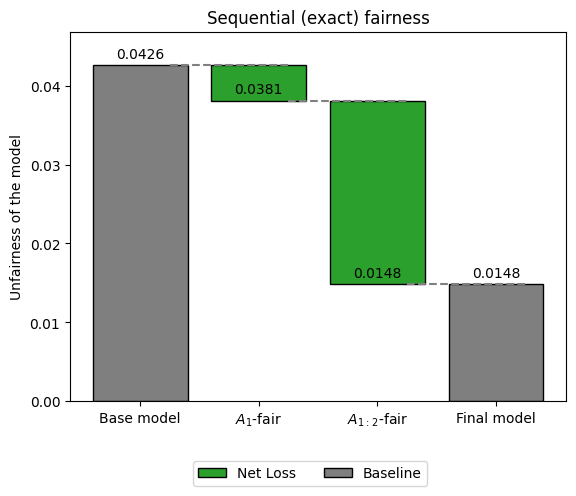

<Axes: title={'center': 'Sequential (exact) fairness'}, ylabel='Unfairness of the model'>

In [235]:
#from equipy.graphs import fair_waterfall_plot

"""
Representation of sequential gain in fairness.
"""

# Authors: Agathe F, Suzie G, Francois H, Philipp R, Arthur C
# License: BSD 3 clause
import matplotlib.pyplot as plt
import numpy as np
import re
from typing import Union, Optional


def _set_colors(substraction_list: list[float]) -> list[str]:
    """
    Assign colors to bars based on the values in the subtraction_list.

    Parameters
    ----------
    subtraction_list : list
        A list of numerical values representing the differences between two sets.

    Returns
    -------
    list
        A list of color codes corresponding to each value in subtraction_list.

    Notes
    -----
    - The color 'tab:orange' is assigned to positive values,
      'tab:green' to non-positive values, and 'tab:grey' to the first and last positions.
    """

    bar_colors = ['tab:grey']
    for i in range(1, len(substraction_list)-1):
        if substraction_list[i] > 0:
            bar_colors.append('tab:orange')
        else:
            bar_colors.append('tab:green')
    bar_colors.append('tab:grey')

    return bar_colors


def _add_bar_labels(values: list[float], pps: list[plt.bar], ax: plt.Axes) -> plt.Axes:
    """
    Add labels to the top of each bar in a bar plot.

    Parameters
    ----------
    values : list
        A list of numerical values representing the heights of the bars.
    pps : list
        A list of bar objects returned by the bar plot.
    ax : matplotlib.axes.Axes
        The Axes on which the bars are plotted.

    Returns
    -------
    matplotlib.axes.Axes
        Text object representing the labels added to the top of each bar in the plot.
    """

    true_values = values + (values[-1],)

    for i, p in enumerate(pps):
        height = true_values[i]
        ax.annotate('{}'.format(height),
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    return ax


def _add_doted_points(ax: plt.Axes, values: np.ndarray) -> plt.Axes:
    """
    Add dotted lines at the top of each bar in a bar plot.

    Parameters
    ----------
    ax : numpy.ndarray
        The Axes on which the bars are plotted.

    values : numpy.ndarray
        An array of numerical values representing the heights of the bars.

    Returns
    -------
    matplotlib.axes.Axes
        The dotted lines at the top of each bar in a bar plot

    This function adds dotted lines at the top of each bar in a bar plot, corresponding to the height values.

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> fig, ax = plt.subplots()
    >>> values = np.array([10, 15, 7, 12, 8])
    >>> add_dotted_lines(ax, values)
    >>> plt.show()
    """
    for i, v in enumerate(values):
        ax.plot([i+0.25, i+1.25], [v, v],
                linestyle='--', linewidth=1.5, c='grey')
    return ax


def _add_legend(pps: list[plt.bar], distance: Union[np.ndarray, list], hatch: bool = False) -> list[plt.bar]:
    """
    Add legend labels to the bar plot based on the distances.

    Parameters
    ----------
    pps : List[plt.bar]
        List of bar objects.
    distance : np.ndarray or list
        Array or list of numerical values representing distances.
    hatch : bool, optional
        If True, uses hatching for the legend labels. Defaults to False.

    Returns
    -------
    List[plt.bar]
        List of bar objects with legend labels added.
    """
    used_labels = set()
    for i, bar in enumerate(pps):
        if i == 0 or i == len(pps)-1:
            continue

        if hatch:
            label = 'Net Loss (if exact)' if distance[i] < 0 else 'Net Gain (if exact)'
        else:
            label = 'Net Loss' if distance[i] < 0 else 'Net Gain'

        if label not in used_labels:
            bar.set_label(label)
            used_labels.add(label)
    return pps


def _values_to_distance(values: list[float]) -> list[float]:
    """
    Convert a list of values to a list of distances between consecutive values.

    Parameters
    ----------
    values : list
        A list of numerical values.

    Returns
    -------
    list
        A list of distances between consecutive values.

    Notes
    -----
    This function calculates the differences between consecutive values in the input list, returning a list
    of distances. The last element in the list is the negation of the last value in the input list.
    """
    arr = np.array(values)
    arr = arr[1:] - arr[:-1]
    distance = list(arr) + [-values[-1]]
    return distance


def fair_waterfall_plot(unfs_exact: dict[str, np.ndarray], unfs_approx: Optional[dict[str, np.ndarray]] = None) -> plt.Axes:
    """
    Generate a waterfall plot illustrating the sequential fairness in a model.

    Parameters
    ----------
    unfs_exact : dict
        Dictionary containing fairness values for each step in the exact fairness scenario.
    unfs_approx : dict, optional
        Dictionary containing fairness values for each step in the approximate fairness scenario. Default is None.

    Returns
    -------
    matplotlib.axes.Axes
        The Figure object representing the waterfall plot.

    Notes
    -----
    The function creates a waterfall plot with bars representing the fairness values at each step.
    If both exact and approximate fairness values are provided, bars are color-coded and labeled accordingly.
    The legend is added to distinguish between different bars in the plot.
    """

    fig, ax = plt.subplots()

    unfs_exact = {key: round(value, 4) for key, value in unfs_exact.items()}
    if unfs_approx is not None:
        unfs_approx = {key: round(value, 4) for key, value in unfs_approx.items()}

    sens = [int(''.join(re.findall(r'\d+', key))) for key in list(unfs_exact.keys())[1:]]

    labels = []
    for i in range(len(list(unfs_exact.keys())[1:])):
        if i == 0: 
            labels.append(f"$A_{sens[i]}$-fair")
        elif i == len(list(unfs_exact.keys())[1:])-1: 
            labels.append(f"$A_{1}$" + r"$_:$" + f"$_{sens[i]}$-fair")
        else:
            labels.append(f"$A_{{{','.join(map(str, sens[0:i+1]))}}}$-fair")

    leg = ('Base model',) + tuple(labels) + ('Final model',)
    base_exact = list(unfs_exact.values())
    values_exact = [0] + base_exact
    distance_exact = _values_to_distance(values_exact)

    if unfs_approx is not None:

        base_approx = list(unfs_approx.values())
        values_approx = [0] + base_approx
        distance_approx = _values_to_distance(values_approx)

        # waterfall for gray hashed color
        direction = np.array(distance_exact) > 0

        values_grey = np.zeros(len(values_exact))
        values_grey[direction] = np.array(values_approx)[direction]
        values_grey[~direction] = np.array(values_exact)[~direction]

        distance_grey = np.zeros(len(values_exact))
        distance_grey[direction] = np.array(
            values_exact)[direction] - np.array(values_approx)[direction]
        distance_grey[~direction] = np.array(
            values_approx)[~direction] - np.array(values_exact)[~direction]

        # waterfall for exact fairness
        pps0 = ax.bar(leg, distance_exact, color='w', edgecolor=_set_colors(
            distance_exact), bottom=values_exact, hatch='//')

        _add_legend(pps0, distance_exact, hatch=True)

        ax.bar(leg, distance_grey, color='w', edgecolor="grey",
               bottom=values_grey, hatch='//', label='Remains')

        # waterfall for approx. fairness
        pps = ax.bar(leg, distance_approx, color=_set_colors(
            distance_approx), edgecolor='k', bottom=values_approx, label='Baseline')
        _add_legend(pps, distance_approx)

    else:
        # waterfall for exact fairness
        pps = ax.bar(leg, distance_exact, color=_set_colors(
            distance_exact), edgecolor='k', bottom=values_exact, label='Baseline')
        _add_legend(pps, distance_exact)

    fig.legend(loc='upper center', bbox_to_anchor=(
        0.5, 0), ncol=3, fancybox=True)

    _add_bar_labels(tuple(base_exact)
                    if unfs_approx is None else tuple(base_approx), pps, ax)
    _add_doted_points(ax, tuple(base_exact)
                      if unfs_approx is None else tuple(base_approx))
    ax.set_ylabel(f'Unfairness of the model')
    #ax.set_ylim(0, 1.1)
    ax.set_ylim(0,  np.max(list(unfs_exact.values()))+np.max(list(unfs_exact.values()))/10 if unfs_approx is None 
                else np.max(list(unfs_exact.values(), unfs_approx.values()))+np.max(list(unfs_exact.values(), unfs_approx.values()))/10)
    ax.set_title(
        f'Sequential ({"exact" if unfs_approx is None else "approximate"}) fairness')
    plt.show()
    return ax

fair_waterfall_plot(unfs_exact = unfs_list[0])

# Approximate fairness

In [67]:
# Instance of Wasserstein class with approximate fairness
# Rename datasets to facilitate the EquiPy package application
# Creation of the objects useful for the package
x_ssa_calib = df_calib[['Gender', 'Age']].to_numpy()
x_ssa_test = df_test[['Gender', 'Age']].to_numpy()
approx_wst = fairness.MultiWasserstein()
approx_wst.fit(scores_calib, x_ssa_calib)
epsilon = [0.8, 0.1]
y_final_approx = approx_wst.transform(scores_test, x_ssa_test, epsilon = epsilon)
print("y_fair :", y_final_approx) # returns the y_fair

# To have all the steps of sequential fairness, you can return the dictionnary 
y_seq_approx = approx_wst.y_fair
print("y_sequentially_fair :", y_seq_approx)

# Calculate unfairness
metrics.unfairness(y_final_approx, x_ssa_test)

y_fair : [0.08859789 0.05081342 0.09280048 ... 0.07212823 0.01904291 0.06979801]
y_sequentially_fair : {'Base model': array([0.08098145, 0.04767718, 0.08036998, ..., 0.06823985, 0.01795607,
       0.0657563 ], dtype=float32), 'sensitive_feature_1': array([0.08009221, 0.04691903, 0.08314142, ..., 0.06711218, 0.01855464,
       0.06471421], dtype=float32), 'sensitive_feature_2': array([0.08859789, 0.05081342, 0.09280048, ..., 0.07212823, 0.01904291,
       0.06979801], dtype=float32)}


0.09459790522703121